In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [2]:
para = 'nback'
blacklist = [] # emoid: 180; rest: 220,233,274,284,472

subidsRest = [_id for _id in meta if para in meta[_id] and int(meta[_id][para]) not in blacklist] 

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', para, meta[subid][para]) for subid in subidsRest]

print('Loading complete')
print(len(rest_ts))

Loading complete
907


In [3]:
# Ages and gender

import torch

nTrain = 800

perm = torch.randperm(len(rest_ts))
trainIdx = perm[:nTrain]
testIdx = perm[nTrain:]

ages = []
male = []
female = []
genderFactor = 10_000

for _id in meta:
    if para in meta[_id] and int(meta[_id][para]) not in blacklist:
        ages.append(meta[_id]['meta']['AgeInMonths']/12)
        if meta[_id]['meta']['Gender'] == 'M':
            male.append(genderFactor)
            female.append(0)
        elif meta[_id]['meta']['Gender'] == 'F':
            male.append(0)
            female.append(genderFactor)
        else:
            raise Exception(f'Gender error sub {_id}')

ages = torch.tensor(ages).float()
ages_train = ages[trainIdx].cuda()
ages_test = ages[testIdx].cuda()

male = torch.tensor(male).float()
female = torch.tensor(female).float()

print(ages.shape)
print(ages_train.shape)
print(ages_test.shape)
print(male.shape)
print(female.shape)

torch.Size([907])
torch.Size([800])
torch.Size([107])
torch.Size([907])
torch.Size([907])


In [4]:
# Convert to pytorch
# Split into train and test

import numpy as np
import torch

def makePoly(np, order):
    nps = [np]
    for i in range(order-1):
        nps.append(nps[-1]*np)
    return torch.cat(nps,dim=1)

rest_p_t = torch.from_numpy(np.stack([np.corrcoef(ts) for ts in rest_ts])).float()
# rest_p_t = makePoly(rest_p_t, 3)
# rest_p_t = torch.concat([rest_p_t,male.unsqueeze(1),female.unsqueeze(1)],dim=1)

rest_p_t_train = rest_p_t[trainIdx].cuda()
rest_p_t_test = rest_p_t[testIdx].cuda()

print(rest_p_t.shape)
print(rest_p_t_train.shape)
print(rest_p_t_test.shape)

torch.Size([907, 264, 264])
torch.Size([800, 264, 264])
torch.Size([107, 264, 264])


In [15]:
import torch.nn as nn
import torch.nn.functional as F
import itertools
import random
import copy

nConnEdge = rest_p_t.shape[1]
# nHid = 30

class DiffGraph(nn.Module):
    def __init__(self):
        super(DiffGraph, self).__init__()
        self.conv1 = nn.Conv2d(1,10,[8,8],stride=4).float().cuda()
        self.bn = nn.BatchNorm2d(10).float().cuda()
        self.fc1 = nn.Linear(2*10*65*65,1).float().cuda()
        
    def forward(self, x):
        x,y = x[0].unsqueeze(1),x[1].unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = self.bn(x)
        x = x.reshape(-1,10*65*65)
        y = F.relu(self.conv1(y))
        y = self.bn(y)
        y = y.reshape(-1,10*65*65)
        x = self.fc1(torch.cat([x,y],dim=1))
        return x
    
dg = DiffGraph()
optim = torch.optim.Adam(dg.parameters(), lr=1e-4, weight_decay=0.1)

nEpoch = 10
bSize = 1000
pPeriod = 10000

pairs = list(itertools.combinations_with_replacement(np.arange(nTrain),2))

for i in range(nEpoch):
    randPairs = copy.copy(pairs)
    random.shuffle(randPairs)
    nComplete = 0
    print(f'epoch {i}')
    while nComplete < len(pairs):
        todo = len(pairs)-nComplete
        if todo > bSize:
            todo = bSize
        batchPairs = randPairs[nComplete:nComplete+todo]
        Ai, Bi = zip(*batchPairs)
        A = rest_p_t_train[Ai,:,:]
        B = rest_p_t_train[Bi,:,:]
        a = ages_train[list(Ai)]
        b = ages_train[list(Bi)]
        optim.zero_grad()
#         pos = torch.cat([A,B],dim=1)
#         neg = torch.cat([B,A],dim=1)
        posRes = dg([A,B]).flatten()
        negRes = dg([B,A]).flatten()
        posLoss = torch.mean((posRes-(a-b))**2)**0.5
        negLoss = torch.mean((negRes-(b-a))**2)**0.5
        (posLoss+negLoss).backward()
        optim.step()
        if nComplete % pPeriod == 0:
            print(f'\tposLoss={posLoss} negLoss={negLoss} complete={nComplete}')
        nComplete += todo
        
print('Complete')

epoch 0
	posLoss=4.733148097991943 negLoss=4.711851119995117 complete=0
	posLoss=3.250007390975952 negLoss=3.2462546825408936 complete=10000
	posLoss=2.6734206676483154 negLoss=2.6529974937438965 complete=20000
	posLoss=2.024005651473999 negLoss=2.0049686431884766 complete=30000
	posLoss=1.5136264562606812 negLoss=1.5186173915863037 complete=40000
	posLoss=1.1207821369171143 negLoss=1.1169617176055908 complete=50000
	posLoss=0.8220802545547485 negLoss=0.8324809074401855 complete=60000
	posLoss=0.5303221940994263 negLoss=0.5026697516441345 complete=70000
	posLoss=0.34790873527526855 negLoss=0.36956384778022766 complete=80000
	posLoss=0.2788639962673187 negLoss=0.2613687813282013 complete=90000
	posLoss=0.5438904166221619 negLoss=0.557356059551239 complete=100000
	posLoss=0.4230256676673889 negLoss=0.4412213861942291 complete=110000
	posLoss=0.6575173735618591 negLoss=0.6132709980010986 complete=120000
	posLoss=0.2420860379934311 negLoss=0.12915772199630737 complete=130000
	posLoss=0.473

KeyboardInterrupt: 

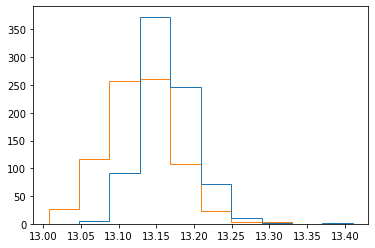

tensor(9.6667, device='cuda:0')


In [23]:
# Test 1 subject

import matplotlib.pyplot as plt

idx = 2

A = rest_p_t_test[idx].expand(nTrain,-1,-1)
a = ages_test[idx].expand(nTrain)

B = rest_p_t_train
b = ages_train

# pos = torch.cat([A,B],dim=1)
# neg = torch.cat([B,A],dim=1)
posRes = dg([A,B]).flatten()
negRes = dg([B,A]).flatten()

agePos = posRes + b
ageNeg = b - negRes

ap = agePos.detach().cpu().numpy()
an = ageNeg.detach().cpu().numpy()

plt.hist([ap, an], histtype='step')
plt.show()

print(a[0])

done 0
done 20
done 40
done 60
done 80
done 100
Positive
[[1.         0.72470814]
 [0.72470814 1.        ]]
2.367107518024895
1.8861548432679933
Negative
[[1.         0.72497418]
 [0.72497418 1.        ]]
2.364972607394574
1.877130918413679
Mean
[[1.         0.72782853]
 [0.72782853 1.        ]]
2.3561239768892466
1.880467410399535
Least squares
[[1.         0.79417399]
 [0.79417399 1.        ]]
2.0814310035238783
1.722446


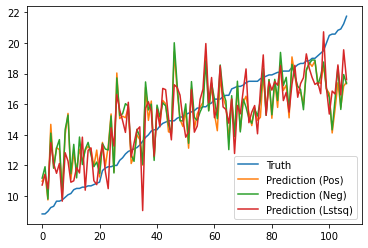

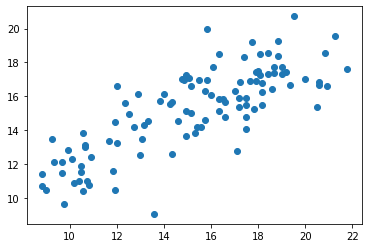

In [24]:
# Test

ap = np.zeros(len(testIdx))
an = np.zeros(len(testIdx))

for i in range(rest_p_t_test.shape[0]):
    if i % 20 == 0:
        print(f'done {i}')
    A = rest_p_t_test[i].expand(nTrain,-1,-1)
    a = ages_test[i].expand(nTrain)

    B = rest_p_t_train
    b = ages_train

#     pos = torch.cat([A,B],dim=1)
#     neg = torch.cat([B,A],dim=1)
    posRes = dg([A,B]).flatten()
    negRes = dg([B,A]).flatten()

    agePos = posRes + b
    ageNeg = b - negRes

    ap[i] = torch.mean(agePos).detach().cpu().numpy()
    an[i] = torch.mean(ageNeg).detach().cpu().numpy()

# pred = gat(rest_ts_t_test)
# pred = pred.flatten().detach().cpu().numpy()
y = ages_test.detach().cpu().numpy()

idcs = np.argsort(y)
ap = ap[idcs]
an = an[idcs]
am = (ap+an)/2
y = y[idcs]

print('Positive')

corr = np.corrcoef(y, ap)
rmse = np.mean((y-ap)**2)**0.5
mae = np.mean(np.abs(y-ap))

print(corr)
print(rmse)
print(mae)

print('Negative')

corr = np.corrcoef(y, an)
rmse = np.mean((y-an)**2)**0.5
mae = np.mean(np.abs(y-an))

print(corr)
print(rmse)
print(mae)

print('Mean')

corr = np.corrcoef(y, am)
rmse = np.mean((y-am)**2)**0.5
mae = np.mean(np.abs(y-am))

print(corr)
print(rmse)
print(mae)

w,_,_,_ = torch.linalg.lstsq(rest_p_t_train.reshape(-1,264*264),ages_train)

a = rest_p_t_test.reshape(-1,264*264)@w
a = a.detach().cpu().numpy()
y = ages_test.detach().cpu().numpy()

idcs = np.argsort(y)
a = a[idcs]
y = y[idcs]

print('Least squares')

corr = np.corrcoef(y, a)
rmse = np.mean((y-a)**2)**0.5
mae = np.mean(np.abs(y-a))

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(ap, label='Prediction (Pos)')
plt.plot(an, label='Prediction (Neg)')
plt.plot(a, label='Prediction (Lstsq)')
plt.legend()
plt.show()

plt.scatter(y, a)
plt.show()

In [8]:
ep = np.zeros([nTrain,nTrain])
en = np.zeros([nTrain,nTrain])

bSize = 100

for i in range(rest_p_t_train.shape[0]):
    
    nComplete = 0
    while nComplete < nTrain:
        todo = nTrain-nComplete
        if todo > bSize:
            todo = bSize
        
        A = rest_p_t_train[i].expand(todo,-1)
        a = ages_train[i].expand(todo)

        B = rest_p_t_train[nComplete:nComplete+todo]
        b = ages_train[nComplete:nComplete+todo]

        pos = torch.cat([A,B],dim=1)
        neg = torch.cat([B,A],dim=1)
        posRes = (dg(pos).flatten()-(a-b)).detach().cpu().numpy()
        negRes = (dg(neg).flatten()-(b-a)).detach().cpu().numpy()
        
        optim.zero_grad()

        ep[i,nComplete:nComplete+todo] = posRes
        en[i,nComplete:nComplete+todo] = negRes
    
        nComplete += todo
        
    if i % 50 == 0:
        print(f'done {i}')
    
print('Complete')

done 0
done 50
done 100
done 150
done 200
done 250
done 300
done 350
done 400
done 450
done 500
done 550
Complete


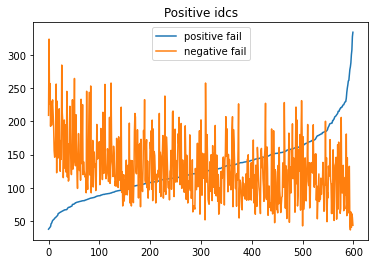

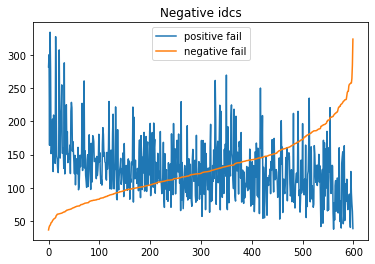

In [9]:
errP = np.sum(np.abs(ep),axis=0)
errN = np.sum(np.abs(en),axis=0)

idcsP = np.argsort(errP)
plt.plot(errP[idcsP],label='positive fail')
plt.plot(errN[idcsP],label='negative fail')
plt.legend()
plt.title('Positive idcs')
plt.show()

idcsN = np.argsort(errN)
plt.plot(errP[idcsN],label='positive fail')
plt.plot(errN[idcsN],label='negative fail')
plt.legend()
plt.title('Negative idcs')
plt.show()

In [104]:
ap = np.zeros(len(testIdx))
an = np.zeros(len(testIdx))

for i in range(rest_p_t_test.shape[0]):
    if i % 20 == 0:
        print(f'done {i}')
    A = rest_p_t_test[i].expand(nTrain,-1)
    a = ages_test[i].expand(nTrain)

    B = rest_p_t_train
    b = ages_train

    pos = torch.cat([A,B],dim=1)
    neg = torch.cat([B,A],dim=1)
    posRes = dg(pos).flatten()
    negRes = dg(neg).flatten()

    agePos = posRes + b
    ageNeg = b - negRes
    
    agePos = agePos.detach().cpu().numpy()
    ageNeg = ageNeg.detach().cpu().numpy()

    ap[i] = np.mean(agePos[idcsP[:-50]])
    an[i] = np.mean(ageNeg[idcsN[:-50]])

done 0
done 20
done 40
done 60
done 80
done 100
done 120


In [105]:
err = ap-ages_test.detach().cpu().numpy()
print(np.mean(np.abs(err)))

2.158888506695507


In [23]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1200 MB |   10501 MB |    6329 GB |    6327 GB |
|       from large pool |    1198 MB |   10499 MB |    6318 GB |    6317 GB |
|       from small pool |       2 MB |       3 MB |      10 GB |      10 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1200 MB |   10501 MB |    6329 GB |    6327 GB |
|       from large pool |    1198 MB |   10499 MB |    6318 GB |

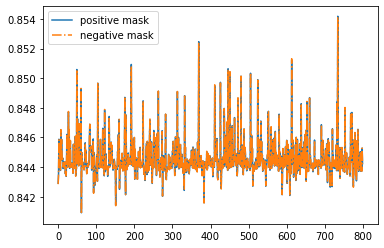

In [74]:
plt.plot(dg.pMask.detach().flatten().cpu().numpy(), label='positive mask')
plt.plot(dg.nMask.detach().flatten().cpu().numpy(), label='negative mask', linestyle='-.')
plt.legend()
plt.show()